In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from pprint import pprint
from rouge import Rouge

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding, Bidirectional, Concatenate
from keras.optimizers import Adam, Nadam
from keras.losses import sparse_categorical_crossentropy, KLDivergence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model

import matplotlib.pyplot as plt 
from keras.regularizers import l2
import os

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/wikihowAll_cleaned.csv', delimiter=',', nrows=180000)

In [3]:
df.head()

,headline,text
0,keep related supplies in the same area make an...,photographer keep necessary lens cord battery ...
1,create a sketch in the neopoprealist manner of...,see image draw develops stepbystep however imp...
2,get a bachelors degree enroll in a studiobased...,possible become vfx artist without college deg...
3,start with some experience or interest in art ...,best art investor research piece art buy someo...
4,keep your reference materials sketches article...,start planning project work shall likely gathe...


In [4]:
df['headline'] = df['headline'].apply(lambda x : '_SOS_ '+ x + ' _EOS_')

In [5]:
df.head()

,headline,text
0,_SOS_ keep related supplies in the same area m...,photographer keep necessary lens cord battery ...
1,_SOS_ create a sketch in the neopoprealist man...,see image draw develops stepbystep however imp...
2,_SOS_ get a bachelors degree enroll in a studi...,possible become vfx artist without college deg...
3,_SOS_ start with some experience or interest i...,best art investor research piece art buy someo...
4,_SOS_ keep your reference materials sketches a...,start planning project work shall likely gathe...


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train, test = train_test_split(df, test_size=0.05, random_state=42, shuffle=True)

In [8]:
train, val = train_test_split(train, test_size=0.056, random_state=42, shuffle=True)

In [9]:
train.shape

(156617, 2)

In [10]:
test.shape

(8733, 2)

In [11]:
val.shape

(9291, 2)

In [12]:
max_len_text = 80 
max_len_summary = 20

In [13]:
X_train = train['text'].astype(str).values.tolist()
X_test = test['text'].astype(str).values.tolist()
X_val = val['text'].astype(str).values.tolist()

Y_train = train['headline'].astype(str).values.tolist()
Y_test = test['headline'].astype(str).values.tolist()
Y_val = val['headline'].astype(str).values.tolist()

Keras padding https://keras.io/guides/understanding_masking_and_padding/

In [14]:
x_vocab = 25000

x_tokenizer = Tokenizer(num_words=x_vocab)
x_tokenizer.fit_on_texts(X_train)

x_train = x_tokenizer.texts_to_sequences(X_train)
x_val = x_tokenizer.texts_to_sequences(X_val)
x_test = x_tokenizer.texts_to_sequences(X_test)

x_train = pad_sequences(x_train, maxlen=max_len_text, padding="post")
x_val = pad_sequences(x_val, maxlen=max_len_text, padding="post")
x_test = pad_sequences(x_test, maxlen=max_len_text, padding="post")

y_vocab = 10000

y_tokenizer = Tokenizer(num_words=y_vocab)
y_tokenizer.fit_on_texts(Y_train)

y_train= y_tokenizer.texts_to_sequences(Y_train)
y_val = y_tokenizer.texts_to_sequences(Y_val)
y_test = y_tokenizer.texts_to_sequences(Y_test)

y_train = pad_sequences(y_train, maxlen=max_len_summary, padding="post")
y_val = pad_sequences(y_val, maxlen=max_len_summary, padding="post")
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding="post")

In [15]:
latent_dim = 400

In [16]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [17]:
model = load_model("seq2seq_180000.h5")

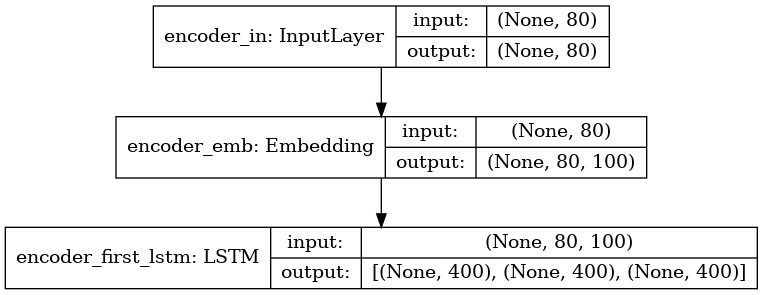

In [18]:
# encoder inference
encoder_inputs = model.input[0]

encoder_embedding_layer = model.layers[2]
encoder_embedding = encoder_embedding_layer(encoder_inputs)

encoder_outputs, state_h_enc, state_c_enc = model.layers[4](encoder_embedding) #last lstm layer
encoder_states = [state_h_enc, state_c_enc]

encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_model_plot.png', show_shapes=True, show_layer_names=True)

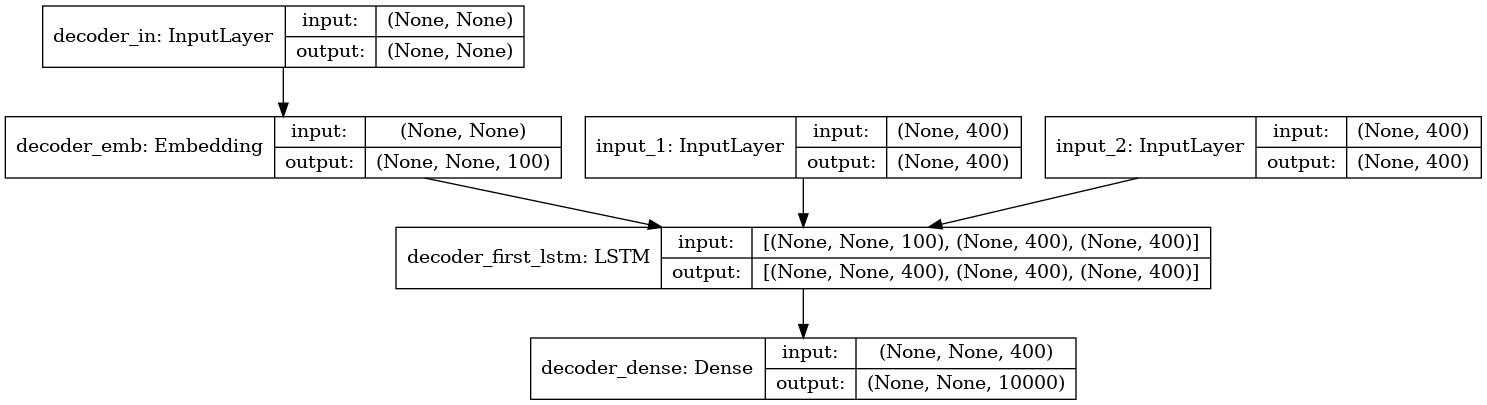

In [19]:
# decoder inference
decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_layer = model.layers[3]
decoder_embedding = decoder_embedding_layer(decoder_inputs)

decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h_dec, state_c_dec]

decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [21]:
def n_max_elements(data, n):
    elems = []
    indexs = []
  
    for i in range(0, n): 
        max_ = 0
        index = 0
          
        for j in range(len(data)):     
            if data[j] > max_ and data[j] not in elems:
                max_ = data[j];
                index = j
                  
        elems.append(max_)
        indexs.append(index)
          
    return elems, indexs

In [22]:
def close_to_num(data, num):
    elem = 0
    index = 0
 
    for j in range(len(data)):     
        if data[j] > elem and data[j] < num:
            elem = data[j];
            index = j
          
    return elem, index

In [23]:
def top_k_sampling(data, k):
    pred = data[0]
    top_k_prob, top_k_index = n_max_elements(pred, k)
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [24]:
def nucleus_sampling(data, p):
    pred = data[0]
    sum_ = 0
    top_k_prob = []
    top_k_index = []
    prob = 1
    while sum_ <= p:
        prob, index = close_to_num(pred, prob)
        top_k_prob.append(prob)
        top_k_index.append(index)
        sum_ += prob
    top_k_prob_soft = softmax(np.log(top_k_prob))
    sampled_token = np.random.choice(top_k_index, p=top_k_prob_soft)
    return sampled_token

In [25]:
def beam_search_decoder(data, k=1):
    sequences = [[list(), 0.0]]
    
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score - np.log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:k]
    return sequences

In [26]:
def seq2summary(input_seq):
    summary=''
    for i in input_seq:
        if (i != 0 and i != target_word_index['sos']) and i != target_word_index['eos']:
            summary += reverse_target_word_index[i]+' '           
    return summary

def seq2text(input_seq):
    return x_tokenizer.sequences_to_texts([input_seq])[0]

In [27]:
def decode_sequence_b(input_seq, w):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    sent = ''
    decoded_sentence = [''] * w
    while not stop_condition:
        for j in range(w):
            output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
            # Sample a token
            sampled_token_index = beam_search_decoder(output_tokens[0, -1:], w)
            for i in range(w):
                if sampled_token_index[i][0][0] != 0:
                    sampled_token = reverse_target_word_index[sampled_token_index[i][0][0]]
                else:
                    sampled_token == 'eos'
                if sampled_token != 'eos':
                    decoded_sentence[i] += ' ' + sampled_token

                    # Exit condition: either hit max length or find stop word.
                if sampled_token == 'eos' or len(decoded_sentence[i].split()) > max_len_summary:
                    stop_condition = True
                    sent = decoded_sentence[i]

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index[j][0][0]

            # Update internal states
            states_value = [h, c]

    return sent

In [28]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :] )   
        sampled_token_index = top_k_sampling(output_tokens[0, -1:], 10)
#         sampled_token_index = nucleus_sampling(output_tokens[0, -1:], 0.4)
        
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eos':
            decoded_sentence += ' ' + sampled_token

            # Exit condition: either hit max length or find stop word.
        if sampled_token == 'eos' or len(decoded_sentence.split()) > max_len_summary:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        states_value = [h, c]

    return decoded_sentence

In [30]:
i=320
print("Review:", seq2text(x_test[i]))
orig = seq2summary(y_test[i])
print("\nOriginal summary:", orig)
pred = decode_sequence(x_test[i].reshape(1, max_len_text))
print("\nPredicted summary:", pred)
print("\n\n")

Review: interview local temporary job placement agency recruiter find job include education work experience skill cooking cleaning organize proof resume well ensure portrays hard worker desire work hospitality industry may also require write cover letter explain experience skill prose keep cover letter page explain skill honor success culinary field far essential education experience able get entry level job kitchen assistant look job give job training promote within ask temp agency give extra consideration job contract extend make permanent job good fit

Original summary: place at a temp agency complete your resume apply for jobs online in person and through your temp agency 

Predicted summary:  get certified and professional jobs get professional





In [29]:
from rouge import Rouge

In [38]:
reference = []
j = 0
while len(reference) < 1000:
    reference.append(seq2summary(y_test[j]))
    j += 1

In [39]:
reference[0:5]

['it select the files you want to unzip tap the unzip button follow the prompts to unzip the file ',
 'keep track of your symptoms assess your symptoms contact your doctor get a diagnosis follow your doctors treatment advice ',
 'andor grass play remember always have fun with your horse and make sure that heshe is having fun too ',
 'the situation make your confrontation about their actions use simple comments listen to the speakers defense try not to ',
 'dont make the connections to the present too be careful how you write about technology avoid potential historical ']

In [40]:
model_out = []
j = 0
while len(model_out) < 1000:
    model_out.append(decode_sequence(x_test[j].reshape(1, max_len_text)))
    j += 1

In [41]:
model_out[0:5]

[' open an file open the folder file in the zip folder view the files',
 ' check out the diagnosis of an look note check for the causes of infection',
 ' find a horse spot for a horse take a break',
 ' accept what your relationship is and you are in the relationship',
 ' create a list of writing write in your journal writing write a conclusion']

In [42]:
rouge = Rouge()

In [65]:
rouge.get_scores(model_out, reference, avg=True)

{'rouge-1': {'f': 0.14433342718806946,
  'p': 0.19208452188935968,
  'r': 0.1213911390295302},
 'rouge-2': {'f': 0.016445686243909845,
  'p': 0.02230636357106944,
  'r': 0.013825606174870853},
 'rouge-l': {'f': 0.12592609694730897,
  'p': 0.17648482155099837,
  'r': 0.10268979538693239}}

In [51]:
scores = rouge.get_scores(model_out, reference)

In [74]:
a_key = "rouge-l"
values_rouge_1 = [a_dict[a_key] for a_dict in scores]

In [81]:
a_key = "r"
values_rouge_1_p = [a_dict[a_key] for a_dict in values_rouge_1]

In [83]:
max(values_rouge_1_p)

0.46153846153846156